# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   str     1206 non-null   int64 
 1   cha     1206 non-null   int64 
 2   ac      1206 non-null   int64 
 3   con     1206 non-null   int64 
 4   book    1206 non-null   object
 5   level   1206 non-null   int64 
 6   dex     1206 non-null   int64 
 7   wis     1206 non-null   int64 
 8   hp      1206 non-null   int64 
 9   int     1206 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 103.6+ KB


In [3]:
df.head()

,str,cha,ac,con,book,level,dex,wis,hp,int
0,7,1,29,5,Pathfinder Bestiary,10,2,2,215,1
1,9,1,28,5,Pathfinder Bestiary,10,0,2,220,-4
2,7,-2,25,6,Pathfinder Bestiary,8,3,3,175,-4
3,7,6,41,5,Pathfinder Bestiary,17,4,5,315,6
4,-5,1,16,1,Pathfinder Bestiary,1,3,1,20,-1


###### Level

In [4]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


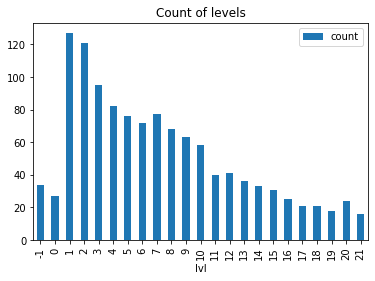

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 8
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, median_absolute_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = median_absolute_error(y_test, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.45
RMSE: 0.67
MAE: 0.33


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Number of characteristics": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "normal", len(X_test.columns), mse, rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.31
RMSE test: 0.67


In [17]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 0.45
RMSE: 0.67

Round type: round
MSE: 0.50
RMSE: 0.71

Round type: 0.33
MSE: 0.50
RMSE: 0.71

Round type: 0.45
MSE: 0.48
RMSE: 0.70



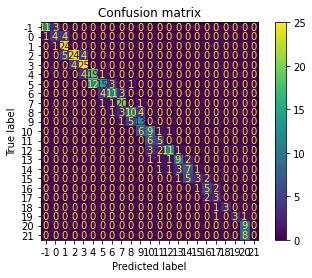

In [18]:
plot_confusion_matrix("round", y_pred_test, y_test)

#### Tuning

In [19]:
from training.results import assess_regression_model

In [20]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-10-28 18:25:08,873] A new study created in memory with name: no-name-dd0beb93-c13c-4e02-a710-1505a69d812f
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.227338 + 0.0489485
[200]	cv_agg's l2: 0.223643 + 0.047603


feature_fraction, val_score: 0.223311:  14%|######4                                      | 1/7 [00:01<00:09,  1.65s/it]

[300]	cv_agg's l2: 0.226379 + 0.0491661
Early stopping, best iteration is:
[207]	cv_agg's l2: 0.223311 + 0.0474948
[100]	cv_agg's l2: 0.234102 + 0.0514901
[200]	cv_agg's l2: 0.232555 + 0.0495999


feature_fraction, val_score: 0.223311:  29%|############8                                | 2/7 [00:02<00:07,  1.40s/it]

[300]	cv_agg's l2: 0.234555 + 0.0509719
Early stopping, best iteration is:
[207]	cv_agg's l2: 0.223311 + 0.0474948
[100]	cv_agg's l2: 0.227133 + 0.0527111
[200]	cv_agg's l2: 0.221337 + 0.0517455


feature_fraction, val_score: 0.221088:  43%|###################2                         | 3/7 [00:04<00:05,  1.40s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.221088 + 0.051289
[100]	cv_agg's l2: 0.297439 + 0.041271
[200]	cv_agg's l2: 0.266457 + 0.042124


feature_fraction, val_score: 0.221088:  57%|#########################7                   | 4/7 [00:06<00:05,  1.69s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.221088 + 0.051289
[100]	cv_agg's l2: 0.227338 + 0.0489485
[200]	cv_agg's l2: 0.223643 + 0.047603


feature_fraction, val_score: 0.221088:  71%|################################1            | 5/7 [00:08<00:04,  2.01s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.221088 + 0.051289
[100]	cv_agg's l2: 0.229599 + 0.046711
[200]	cv_agg's l2: 0.224546 + 0.0450177


feature_fraction, val_score: 0.221088:  86%|######################################5      | 6/7 [00:11<00:02,  2.30s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.221088 + 0.051289
[100]	cv_agg's l2: 0.226597 + 0.0419196
[200]	cv_agg's l2: 0.225353 + 0.0405822


feature_fraction, val_score: 0.221088: 100%|#############################################| 7/7 [00:14<00:00,  2.10s/it]


Early stopping, best iteration is:
[194]	cv_agg's l2: 0.221088 + 0.051289


num_leaves, val_score: 0.221088:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.227133 + 0.0527111
[200]	cv_agg's l2: 0.221337 + 0.0517455


num_leaves, val_score: 0.221088:   5%|##5                                               | 1/20 [00:02<00:53,  2.83s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.221088 + 0.051289
[100]	cv_agg's l2: 0.227133 + 0.0527111
[200]	cv_agg's l2: 0.221337 + 0.0517455


num_leaves, val_score: 0.221088:  10%|#####                                             | 2/20 [00:05<00:51,  2.86s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.221088 + 0.051289
[100]	cv_agg's l2: 0.227133 + 0.0527111
[200]	cv_agg's l2: 0.221337 + 0.0517455


num_leaves, val_score: 0.221088:  15%|#######5                                          | 3/20 [00:09<00:53,  3.15s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.221088 + 0.051289
[100]	cv_agg's l2: 0.234295 + 0.0450901
[200]	cv_agg's l2: 0.224106 + 0.037863
[300]	cv_agg's l2: 0.22037 + 0.0360985


num_leaves, val_score: 0.220056:  20%|##########                                        | 4/20 [00:10<00:40,  2.56s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.220056 + 0.03619
[100]	cv_agg's l2: 0.27812 + 0.0608772
[200]	cv_agg's l2: 0.253471 + 0.0503903
[300]	cv_agg's l2: 0.244939 + 0.0411719


num_leaves, val_score: 0.220056:  25%|############5                                     | 5/20 [00:11<00:29,  1.96s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.220056 + 0.03619
[100]	cv_agg's l2: 0.227133 + 0.0527111
[200]	cv_agg's l2: 0.221337 + 0.0517455
[300]	cv_agg's l2: 0.223131 + 0.0507776


num_leaves, val_score: 0.220056:  30%|###############                                   | 6/20 [00:16<00:42,  3.03s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.220056 + 0.03619
[100]	cv_agg's l2: 0.227133 + 0.0527111
[200]	cv_agg's l2: 0.221337 + 0.0517455
[300]	cv_agg's l2: 0.223131 + 0.0507776


num_leaves, val_score: 0.220056:  35%|#################5                                | 7/20 [00:22<00:50,  3.87s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.220056 + 0.03619
[100]	cv_agg's l2: 0.227133 + 0.0527111
[200]	cv_agg's l2: 0.221337 + 0.0517455
[300]	cv_agg's l2: 0.223131 + 0.0507776


num_leaves, val_score: 0.220056:  40%|####################                              | 8/20 [00:26<00:46,  3.91s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.220056 + 0.03619
[100]	cv_agg's l2: 0.227133 + 0.0527111
[200]	cv_agg's l2: 0.221337 + 0.0517455
[300]	cv_agg's l2: 0.223131 + 0.0507776


num_leaves, val_score: 0.220056:  45%|######################5                           | 9/20 [00:30<00:42,  3.85s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.220056 + 0.03619
[100]	cv_agg's l2: 0.227133 + 0.0527111
[200]	cv_agg's l2: 0.221337 + 0.0517455
[300]	cv_agg's l2: 0.223131 + 0.0507776


num_leaves, val_score: 0.220056:  50%|########################5                        | 10/20 [00:33<00:38,  3.82s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.220056 + 0.03619
[100]	cv_agg's l2: 0.227133 + 0.0527111
[200]	cv_agg's l2: 0.221337 + 0.0517455
[300]	cv_agg's l2: 0.223131 + 0.0507776


num_leaves, val_score: 0.220056:  55%|##########################9                      | 11/20 [00:37<00:33,  3.72s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.220056 + 0.03619
[100]	cv_agg's l2: 0.375718 + 0.0847089
[200]	cv_agg's l2: 0.332161 + 0.076478
[300]	cv_agg's l2: 0.319256 + 0.0727723


num_leaves, val_score: 0.220056:  60%|#############################4                   | 12/20 [00:38<00:22,  2.77s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.220056 + 0.03619
[100]	cv_agg's l2: 0.227133 + 0.0527111
[200]	cv_agg's l2: 0.221337 + 0.0517455
[300]	cv_agg's l2: 0.223131 + 0.0507776


num_leaves, val_score: 0.220056:  65%|###############################8                 | 13/20 [00:41<00:21,  3.09s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.220056 + 0.03619
[100]	cv_agg's l2: 0.227133 + 0.0527111
[200]	cv_agg's l2: 0.221337 + 0.0517455
[300]	cv_agg's l2: 0.223131 + 0.0507776


num_leaves, val_score: 0.220056:  70%|##################################3              | 14/20 [00:45<00:19,  3.25s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.220056 + 0.03619
[100]	cv_agg's l2: 0.227133 + 0.0527111
[200]	cv_agg's l2: 0.221337 + 0.0517455
[300]	cv_agg's l2: 0.223131 + 0.0507776


num_leaves, val_score: 0.220056:  75%|####################################7            | 15/20 [00:49<00:16,  3.37s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.220056 + 0.03619
[100]	cv_agg's l2: 0.227133 + 0.0527111
[200]	cv_agg's l2: 0.221337 + 0.0517455
[300]	cv_agg's l2: 0.223131 + 0.0507776


num_leaves, val_score: 0.220056:  80%|#######################################2         | 16/20 [00:52<00:13,  3.46s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.220056 + 0.03619
[100]	cv_agg's l2: 0.226647 + 0.052229
[200]	cv_agg's l2: 0.219891 + 0.0521737


num_leaves, val_score: 0.219666:  85%|#########################################6       | 17/20 [00:55<00:09,  3.25s/it]

Early stopping, best iteration is:
[199]	cv_agg's l2: 0.219666 + 0.0521247
[100]	cv_agg's l2: 0.227142 + 0.0499832
[200]	cv_agg's l2: 0.219754 + 0.0480259


num_leaves, val_score: 0.219114:  90%|############################################1    | 18/20 [00:57<00:05,  2.97s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.219114 + 0.0477625
[100]	cv_agg's l2: 0.227142 + 0.0499832
[200]	cv_agg's l2: 0.219754 + 0.0480259


num_leaves, val_score: 0.219114:  95%|##############################################5  | 19/20 [01:00<00:02,  2.76s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.219114 + 0.0477625
[100]	cv_agg's l2: 0.225869 + 0.0539048
[200]	cv_agg's l2: 0.221343 + 0.0515048


num_leaves, val_score: 0.219114: 100%|#################################################| 20/20 [01:02<00:00,  3.14s/it]


Early stopping, best iteration is:
[193]	cv_agg's l2: 0.219114 + 0.0477625


bagging, val_score: 0.219114:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.248247 + 0.0663772
[200]	cv_agg's l2: 0.23779 + 0.058084


bagging, val_score: 0.219114:  10%|#####3                                               | 1/10 [00:02<00:19,  2.21s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.219114 + 0.0477625
[100]	cv_agg's l2: 0.328271 + 0.0887016
[200]	cv_agg's l2: 0.313798 + 0.081584


bagging, val_score: 0.219114:  20%|##########6                                          | 2/10 [00:03<00:14,  1.79s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.219114 + 0.0477625
[100]	cv_agg's l2: 0.227159 + 0.0521847
[200]	cv_agg's l2: 0.222211 + 0.0509183


bagging, val_score: 0.219114:  30%|###############9                                     | 3/10 [00:06<00:14,  2.11s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.219114 + 0.0477625
[100]	cv_agg's l2: 0.269301 + 0.0722464
[200]	cv_agg's l2: 0.262182 + 0.0694427


bagging, val_score: 0.219114:  40%|#####################2                               | 4/10 [00:08<00:12,  2.03s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.219114 + 0.0477625
[100]	cv_agg's l2: 0.265703 + 0.071605
[200]	cv_agg's l2: 0.250657 + 0.0732014


bagging, val_score: 0.219114:  50%|##########################5                          | 5/10 [00:10<00:10,  2.07s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.219114 + 0.0477625
[100]	cv_agg's l2: 0.230286 + 0.0591588
[200]	cv_agg's l2: 0.221827 + 0.0550214


bagging, val_score: 0.219114:  60%|###############################8                     | 6/10 [00:12<00:09,  2.26s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.219114 + 0.0477625
[100]	cv_agg's l2: 0.259263 + 0.0659721
[200]	cv_agg's l2: 0.251097 + 0.0632022


bagging, val_score: 0.219114:  70%|#####################################                | 7/10 [00:14<00:06,  2.19s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.219114 + 0.0477625
[100]	cv_agg's l2: 0.248378 + 0.0586779
[200]	cv_agg's l2: 0.240112 + 0.0573325


bagging, val_score: 0.219114:  80%|##########################################4          | 8/10 [00:17<00:04,  2.26s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.219114 + 0.0477625
[100]	cv_agg's l2: 0.292035 + 0.0686022
[200]	cv_agg's l2: 0.281142 + 0.060083


bagging, val_score: 0.219114:  90%|###############################################7     | 9/10 [00:18<00:02,  2.00s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.219114 + 0.0477625
[100]	cv_agg's l2: 0.281981 + 0.0877347
[200]	cv_agg's l2: 0.279853 + 0.0835249


bagging, val_score: 0.219114: 100%|####################################################| 10/10 [00:20<00:00,  2.05s/it]


Early stopping, best iteration is:
[193]	cv_agg's l2: 0.219114 + 0.0477625


feature_fraction_stage2, val_score: 0.219114:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.227142 + 0.0499832
[200]	cv_agg's l2: 0.219754 + 0.0480259


feature_fraction_stage2, val_score: 0.219114:  17%|######3                               | 1/6 [00:02<00:11,  2.29s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.219114 + 0.0477625
[100]	cv_agg's l2: 0.227142 + 0.0499832
[200]	cv_agg's l2: 0.219754 + 0.0480259


feature_fraction_stage2, val_score: 0.219114:  33%|############6                         | 2/6 [00:04<00:09,  2.31s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.219114 + 0.0477625
[100]	cv_agg's l2: 0.231396 + 0.0508161
[200]	cv_agg's l2: 0.225165 + 0.0486713


feature_fraction_stage2, val_score: 0.219114:  50%|###################                   | 3/6 [00:07<00:07,  2.45s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.219114 + 0.0477625
[100]	cv_agg's l2: 0.227142 + 0.0499832
[200]	cv_agg's l2: 0.219754 + 0.0480259


feature_fraction_stage2, val_score: 0.219114:  67%|#########################3            | 4/6 [00:09<00:04,  2.41s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.219114 + 0.0477625
[100]	cv_agg's l2: 0.231396 + 0.0508161
[200]	cv_agg's l2: 0.225165 + 0.0486713


feature_fraction_stage2, val_score: 0.219114:  83%|###############################6      | 5/6 [00:11<00:02,  2.37s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.219114 + 0.0477625
[100]	cv_agg's l2: 0.227142 + 0.0499832
[200]	cv_agg's l2: 0.219754 + 0.0480259


feature_fraction_stage2, val_score: 0.219114: 100%|######################################| 6/6 [00:14<00:00,  2.36s/it]


Early stopping, best iteration is:
[193]	cv_agg's l2: 0.219114 + 0.0477625


regularization_factors, val_score: 0.219114:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.225936 + 0.0509697
[200]	cv_agg's l2: 0.221076 + 0.0511292


regularization_factors, val_score: 0.219114:   5%|#9                                    | 1/20 [00:02<00:43,  2.27s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.219114 + 0.0477625
[100]	cv_agg's l2: 0.227142 + 0.0499832
[200]	cv_agg's l2: 0.219754 + 0.0480259


regularization_factors, val_score: 0.219114:  10%|###8                                  | 2/20 [00:04<00:41,  2.30s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.219114 + 0.0477625
[100]	cv_agg's l2: 0.255904 + 0.0516672


regularization_factors, val_score: 0.219114:  10%|###8                                  | 2/20 [00:05<00:41,  2.30s/it]

[200]	cv_agg's l2: 0.246633 + 0.0500892
Early stopping, best iteration is:
[193]	cv_agg's l2: 0.219114 + 0.0477625


regularization_factors, val_score: 0.219114:  15%|#####7                                | 3/20 [00:05<00:29,  1.72s/it]

[100]	cv_agg's l2: 0.227142 + 0.0499832
[200]	cv_agg's l2: 0.219754 + 0.0480259


regularization_factors, val_score: 0.219114:  20%|#######6                              | 4/20 [00:08<00:32,  2.01s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.219114 + 0.0477625
[100]	cv_agg's l2: 0.224975 + 0.0504948
[200]	cv_agg's l2: 0.219798 + 0.0527081
[300]	cv_agg's l2: 0.219333 + 0.0522679


regularization_factors, val_score: 0.218291:  25%|#########5                            | 5/20 [00:10<00:34,  2.27s/it]

Early stopping, best iteration is:
[241]	cv_agg's l2: 0.218291 + 0.0512382
[100]	cv_agg's l2: 0.22491 + 0.0509751
[200]	cv_agg's l2: 0.216821 + 0.0489693
[300]	cv_agg's l2: 0.215424 + 0.0494754


regularization_factors, val_score: 0.215420:  30%|###########4                          | 6/20 [00:13<00:35,  2.56s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.21542 + 0.049472
[100]	cv_agg's l2: 0.225121 + 0.0507514
[200]	cv_agg's l2: 0.216751 + 0.0490397
[300]	cv_agg's l2: 0.216213 + 0.0486304


regularization_factors, val_score: 0.215420:  35%|#############3                        | 7/20 [00:17<00:36,  2.79s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.21542 + 0.049472
[100]	cv_agg's l2: 0.224911 + 0.0509752
[200]	cv_agg's l2: 0.216646 + 0.0492461
[300]	cv_agg's l2: 0.216507 + 0.0495161


regularization_factors, val_score: 0.215420:  40%|###############2                      | 8/20 [00:20<00:34,  2.88s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.21542 + 0.049472
[100]	cv_agg's l2: 0.22491 + 0.0509749
[200]	cv_agg's l2: 0.216912 + 0.0488773
[300]	cv_agg's l2: 0.215661 + 0.0492176


regularization_factors, val_score: 0.215420:  45%|#################1                    | 9/20 [00:23<00:32,  2.97s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.21542 + 0.049472
[100]	cv_agg's l2: 0.22491 + 0.050975
[200]	cv_agg's l2: 0.216912 + 0.0488774
[300]	cv_agg's l2: 0.215661 + 0.0492176


regularization_factors, val_score: 0.215420:  50%|##################5                  | 10/20 [00:26<00:30,  3.04s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.21542 + 0.049472
[100]	cv_agg's l2: 0.22491 + 0.0509751
[200]	cv_agg's l2: 0.216425 + 0.0491918
[300]	cv_agg's l2: 0.216136 + 0.0486286


regularization_factors, val_score: 0.215420:  55%|####################3                | 11/20 [00:29<00:27,  3.10s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.21542 + 0.049472
[100]	cv_agg's l2: 0.22491 + 0.050975
[200]	cv_agg's l2: 0.216821 + 0.0489693
[300]	cv_agg's l2: 0.215424 + 0.0494754


regularization_factors, val_score: 0.215420:  60%|######################2              | 12/20 [00:33<00:25,  3.14s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.21542 + 0.049472
[100]	cv_agg's l2: 0.22491 + 0.050975
[200]	cv_agg's l2: 0.216912 + 0.0488774
[300]	cv_agg's l2: 0.215661 + 0.0492176


regularization_factors, val_score: 0.215420:  65%|########################             | 13/20 [00:36<00:22,  3.15s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.21542 + 0.049472
[100]	cv_agg's l2: 0.22491 + 0.0509749
[200]	cv_agg's l2: 0.216912 + 0.0488773
[300]	cv_agg's l2: 0.215661 + 0.0492176


regularization_factors, val_score: 0.215420:  70%|#########################9           | 14/20 [00:39<00:19,  3.20s/it]

Early stopping, best iteration is:
[297]	cv_agg's l2: 0.21542 + 0.049472
[100]	cv_agg's l2: 0.22433 + 0.0501893
[200]	cv_agg's l2: 0.215678 + 0.0475626
[300]	cv_agg's l2: 0.215029 + 0.0490145


regularization_factors, val_score: 0.214722:  75%|###########################7         | 15/20 [00:42<00:16,  3.24s/it]

Early stopping, best iteration is:
[293]	cv_agg's l2: 0.214722 + 0.048726
[100]	cv_agg's l2: 0.227402 + 0.0514265
[200]	cv_agg's l2: 0.22034 + 0.0507243
[300]	cv_agg's l2: 0.219294 + 0.0505312


regularization_factors, val_score: 0.214722:  80%|#############################6       | 16/20 [00:46<00:12,  3.22s/it]

Early stopping, best iteration is:
[293]	cv_agg's l2: 0.214722 + 0.048726
[100]	cv_agg's l2: 0.22424 + 0.0508432
[200]	cv_agg's l2: 0.219638 + 0.0503018
[300]	cv_agg's l2: 0.218929 + 0.0497704


regularization_factors, val_score: 0.214722:  85%|###############################4     | 17/20 [00:49<00:09,  3.18s/it]

Early stopping, best iteration is:
[293]	cv_agg's l2: 0.214722 + 0.048726
[100]	cv_agg's l2: 0.229094 + 0.0543583
[200]	cv_agg's l2: 0.224122 + 0.0543348
[300]	cv_agg's l2: 0.224275 + 0.0545826


regularization_factors, val_score: 0.214722:  90%|#################################3   | 18/20 [00:52<00:06,  3.22s/it]

Early stopping, best iteration is:
[293]	cv_agg's l2: 0.214722 + 0.048726
[100]	cv_agg's l2: 0.224677 + 0.0506113
[200]	cv_agg's l2: 0.219516 + 0.0503737
[300]	cv_agg's l2: 0.219357 + 0.0496998


regularization_factors, val_score: 0.214722:  95%|###################################1 | 19/20 [00:55<00:03,  3.18s/it]

Early stopping, best iteration is:
[293]	cv_agg's l2: 0.214722 + 0.048726
[100]	cv_agg's l2: 0.223832 + 0.0515677
[200]	cv_agg's l2: 0.219651 + 0.0532588
[300]	cv_agg's l2: 0.218612 + 0.0528049


regularization_factors, val_score: 0.214722: 100%|#####################################| 20/20 [00:58<00:00,  2.93s/it]


Early stopping, best iteration is:
[293]	cv_agg's l2: 0.214722 + 0.048726


min_data_in_leaf, val_score: 0.214722:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.202261 + 0.0489687
[200]	cv_agg's l2: 0.200662 + 0.0497399


min_data_in_leaf, val_score: 0.199865:  20%|#########                                    | 1/5 [00:02<00:08,  2.21s/it]

Early stopping, best iteration is:
[171]	cv_agg's l2: 0.199865 + 0.0494923
[100]	cv_agg's l2: 0.204947 + 0.0609919
[200]	cv_agg's l2: 0.203264 + 0.0592265


min_data_in_leaf, val_score: 0.199865:  40%|##################                           | 2/5 [00:04<00:06,  2.18s/it]

Early stopping, best iteration is:
[171]	cv_agg's l2: 0.199865 + 0.0494923
[100]	cv_agg's l2: 0.809796 + 0.1734


min_data_in_leaf, val_score: 0.199865:  60%|###########################                  | 3/5 [00:05<00:03,  1.51s/it]

[200]	cv_agg's l2: 0.794284 + 0.176809
Early stopping, best iteration is:
[171]	cv_agg's l2: 0.199865 + 0.0494923


[I 2023-10-28 18:28:04,751] Trial 65 finished with value: 0.7975904455770981 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.19986506557356673.
min_data_in_leaf, val_score: 0.199865:  60%|###########################                  | 3/5 [00:05<00:03,  1.51s/it]

[100]	cv_agg's l2: 0.335166 + 0.0748881
[200]	cv_agg's l2: 0.324325 + 0.0722832


min_data_in_leaf, val_score: 0.199865:  80%|####################################         | 4/5 [00:06<00:01,  1.39s/it]

Early stopping, best iteration is:
[171]	cv_agg's l2: 0.199865 + 0.0494923
[100]	cv_agg's l2: 0.253901 + 0.0738994
[200]	cv_agg's l2: 0.249987 + 0.0743799


min_data_in_leaf, val_score: 0.199865: 100%|#############################################| 5/5 [00:08<00:00,  1.66s/it]

Early stopping, best iteration is:
[171]	cv_agg's l2: 0.199865 + 0.0494923


In [21]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.19986506557356673
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.0010339522605008619
    lambda_l2: 0.0006660181104644676
    num_leaves: 21
    feature_fraction: 0.6
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 10


In [22]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [23]:
rmse, mse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.64
MSE test: 0.41
MAE test: 0.45



In [24]:
results.loc[1] = [
    "chronological",
    "Optuna",
    len(X_test.columns),
    mse,
    rmse,
    mae,
]

In [25]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.41
RMSE: 0.64

Round type: round
MSE: 0.41
RMSE: 0.64

Round type: 0.33
MSE: 0.43
RMSE: 0.66

Round type: 0.45
MSE: 0.42
RMSE: 0.65



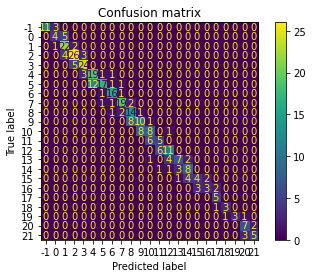

In [26]:
plot_confusion_matrix("round", predict, y_test)

## Random split

In [27]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 8
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[55]	valid_0's l1: 0.340495	valid_0's l2: 0.243018


In [28]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [29]:
from sklearn.metrics import mean_squared_error, median_absolute_error


mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = median_absolute_error(y_test_random_split, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.24
RMSE: 0.49
MAE: 0.24


In [30]:
results.loc[3] = ["random", "normal", len(X_test.columns), mse, rmse, mae]

In [31]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 0.24
RMSE: 0.49

Round type: round
MSE: 0.26
RMSE: 0.51

Round type: 0.33
MSE: 0.32
RMSE: 0.57

Round type: 0.45
MSE: 0.27
RMSE: 0.52



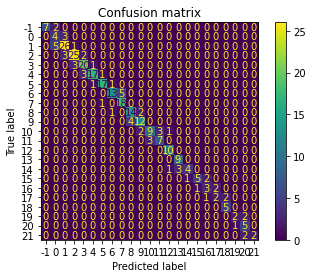

In [32]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

### Tuning

In [33]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-10-28 18:28:23,888] A new study created in memory with name: no-name-ea67fb78-0243-4a00-9f03-803cbf37aa15
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.240166 + 0.0639709


feature_fraction, val_score: 0.239538:  14%|######4                                      | 1/7 [00:02<00:12,  2.02s/it]

[200]	cv_agg's l2: 0.243866 + 0.0619569
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.239538 + 0.0631577
[100]	cv_agg's l2: 0.238861 + 0.0635253


feature_fraction, val_score: 0.238551:  29%|############8                                | 2/7 [00:04<00:10,  2.08s/it]

[200]	cv_agg's l2: 0.241821 + 0.0604441
Early stopping, best iteration is:
[103]	cv_agg's l2: 0.238551 + 0.0632225
[100]	cv_agg's l2: 0.237902 + 0.0636629


feature_fraction, val_score: 0.237517:  43%|###################2                         | 3/7 [00:06<00:07,  1.99s/it]

[200]	cv_agg's l2: 0.240595 + 0.0578711
Early stopping, best iteration is:
[101]	cv_agg's l2: 0.237517 + 0.0635516
[100]	cv_agg's l2: 0.237902 + 0.0636629


feature_fraction, val_score: 0.237517:  57%|#########################7                   | 4/7 [00:07<00:05,  1.97s/it]

[200]	cv_agg's l2: 0.240595 + 0.0578711
Early stopping, best iteration is:
[101]	cv_agg's l2: 0.237517 + 0.0635516
[100]	cv_agg's l2: 0.249628 + 0.0720246


feature_fraction, val_score: 0.237517:  71%|################################1            | 5/7 [00:09<00:03,  1.97s/it]

[200]	cv_agg's l2: 0.251605 + 0.0672733
Early stopping, best iteration is:
[101]	cv_agg's l2: 0.237517 + 0.0635516
[100]	cv_agg's l2: 0.256328 + 0.0777765


feature_fraction, val_score: 0.237517:  86%|######################################5      | 6/7 [00:11<00:01,  1.97s/it]

[200]	cv_agg's l2: 0.259774 + 0.07799
Early stopping, best iteration is:
[101]	cv_agg's l2: 0.237517 + 0.0635516
[100]	cv_agg's l2: 0.31119 + 0.0526924


feature_fraction, val_score: 0.237517: 100%|#############################################| 7/7 [00:13<00:00,  1.97s/it]


[200]	cv_agg's l2: 0.292704 + 0.050197
Early stopping, best iteration is:
[101]	cv_agg's l2: 0.237517 + 0.0635516


num_leaves, val_score: 0.237517:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.237902 + 0.0636629


num_leaves, val_score: 0.237517:   5%|##5                                               | 1/20 [00:02<00:38,  2.01s/it]

[200]	cv_agg's l2: 0.240596 + 0.0578711
Early stopping, best iteration is:
[101]	cv_agg's l2: 0.237517 + 0.0635516
[100]	cv_agg's l2: 0.237902 + 0.0636629


num_leaves, val_score: 0.237517:  10%|#####                                             | 2/20 [00:04<00:38,  2.11s/it]

[200]	cv_agg's l2: 0.240596 + 0.0578711
Early stopping, best iteration is:
[101]	cv_agg's l2: 0.237517 + 0.0635516
[100]	cv_agg's l2: 0.237902 + 0.0636629


num_leaves, val_score: 0.237517:  15%|#######5                                          | 3/20 [00:06<00:34,  2.05s/it]

[200]	cv_agg's l2: 0.240596 + 0.0578711
Early stopping, best iteration is:
[101]	cv_agg's l2: 0.237517 + 0.0635516
[100]	cv_agg's l2: 0.237777 + 0.0634828
[200]	cv_agg's l2: 0.236556 + 0.0580374


num_leaves, val_score: 0.235470:  20%|##########                                        | 4/20 [00:07<00:30,  1.88s/it]

Early stopping, best iteration is:
[169]	cv_agg's l2: 0.23547 + 0.0579005
[100]	cv_agg's l2: 0.247343 + 0.070811


num_leaves, val_score: 0.235470:  25%|############5                                     | 5/20 [00:08<00:21,  1.47s/it]

[200]	cv_agg's l2: 0.238814 + 0.066756
Early stopping, best iteration is:
[169]	cv_agg's l2: 0.23547 + 0.0579005
[100]	cv_agg's l2: 0.237902 + 0.0636629
[200]	cv_agg's l2: 0.240596 + 0.0578711


num_leaves, val_score: 0.235470:  30%|###############                                   | 6/20 [00:11<00:26,  1.88s/it]

Early stopping, best iteration is:
[169]	cv_agg's l2: 0.23547 + 0.0579005
[100]	cv_agg's l2: 0.23435 + 0.0622813


num_leaves, val_score: 0.233415:  35%|#################5                                | 7/20 [00:12<00:21,  1.68s/it]

[200]	cv_agg's l2: 0.234956 + 0.0569665
Early stopping, best iteration is:
[104]	cv_agg's l2: 0.233415 + 0.0611411
[100]	cv_agg's l2: 0.247343 + 0.070811


num_leaves, val_score: 0.233415:  40%|####################                              | 8/20 [00:13<00:15,  1.33s/it]

[200]	cv_agg's l2: 0.238814 + 0.066756
Early stopping, best iteration is:
[104]	cv_agg's l2: 0.233415 + 0.0611411
[100]	cv_agg's l2: 0.237902 + 0.0636629


num_leaves, val_score: 0.233415:  45%|######################5                           | 9/20 [00:15<00:17,  1.59s/it]

[200]	cv_agg's l2: 0.240596 + 0.0578711
Early stopping, best iteration is:
[104]	cv_agg's l2: 0.233415 + 0.0611411
[100]	cv_agg's l2: 0.237902 + 0.0636629


num_leaves, val_score: 0.233415:  50%|########################5                        | 10/20 [00:17<00:17,  1.73s/it]

[200]	cv_agg's l2: 0.240596 + 0.0578711
Early stopping, best iteration is:
[104]	cv_agg's l2: 0.233415 + 0.0611411
[100]	cv_agg's l2: 0.237902 + 0.0636629


num_leaves, val_score: 0.233415:  55%|##########################9                      | 11/20 [00:19<00:16,  1.83s/it]

[200]	cv_agg's l2: 0.240596 + 0.0578711
Early stopping, best iteration is:
[104]	cv_agg's l2: 0.233415 + 0.0611411
[100]	cv_agg's l2: 0.237902 + 0.0636629


num_leaves, val_score: 0.233415:  60%|#############################4                   | 12/20 [00:21<00:15,  1.90s/it]

[200]	cv_agg's l2: 0.240596 + 0.0578711
Early stopping, best iteration is:
[104]	cv_agg's l2: 0.233415 + 0.0611411
[100]	cv_agg's l2: 0.237902 + 0.0636629


num_leaves, val_score: 0.233415:  65%|###############################8                 | 13/20 [00:23<00:13,  1.92s/it]

[200]	cv_agg's l2: 0.240596 + 0.0578711
Early stopping, best iteration is:
[104]	cv_agg's l2: 0.233415 + 0.0611411
[100]	cv_agg's l2: 0.237902 + 0.0636629


num_leaves, val_score: 0.233415:  70%|##################################3              | 14/20 [00:25<00:11,  1.93s/it]

[200]	cv_agg's l2: 0.240596 + 0.0578711
Early stopping, best iteration is:
[104]	cv_agg's l2: 0.233415 + 0.0611411
[100]	cv_agg's l2: 0.237902 + 0.0636629


num_leaves, val_score: 0.233415:  75%|####################################7            | 15/20 [00:27<00:10,  2.01s/it]

[200]	cv_agg's l2: 0.240596 + 0.0578711
Early stopping, best iteration is:
[104]	cv_agg's l2: 0.233415 + 0.0611411
[100]	cv_agg's l2: 0.237902 + 0.0636629


num_leaves, val_score: 0.233415:  80%|#######################################2         | 16/20 [00:29<00:08,  2.03s/it]

[200]	cv_agg's l2: 0.240595 + 0.0578711
Early stopping, best iteration is:
[104]	cv_agg's l2: 0.233415 + 0.0611411
[100]	cv_agg's l2: 0.237902 + 0.0636629


num_leaves, val_score: 0.233415:  85%|#########################################6       | 17/20 [00:31<00:06,  2.04s/it]

[200]	cv_agg's l2: 0.240596 + 0.0578711
Early stopping, best iteration is:
[104]	cv_agg's l2: 0.233415 + 0.0611411
[100]	cv_agg's l2: 0.248402 + 0.072121


num_leaves, val_score: 0.233415:  90%|############################################1    | 18/20 [00:32<00:03,  1.62s/it]

[200]	cv_agg's l2: 0.242157 + 0.0686725
Early stopping, best iteration is:
[104]	cv_agg's l2: 0.233415 + 0.0611411
[100]	cv_agg's l2: 0.237902 + 0.0636629


num_leaves, val_score: 0.233415:  95%|##############################################5  | 19/20 [00:34<00:01,  1.74s/it]

[200]	cv_agg's l2: 0.240596 + 0.0578711
Early stopping, best iteration is:
[104]	cv_agg's l2: 0.233415 + 0.0611411
[100]	cv_agg's l2: 0.237902 + 0.0636629


num_leaves, val_score: 0.233415: 100%|#################################################| 20/20 [00:36<00:00,  1.82s/it]


[200]	cv_agg's l2: 0.240596 + 0.0578711
Early stopping, best iteration is:
[104]	cv_agg's l2: 0.233415 + 0.0611411


bagging, val_score: 0.233415:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.264046 + 0.0656585


bagging, val_score: 0.233415:  10%|#####3                                               | 1/10 [00:01<00:12,  1.39s/it]

[200]	cv_agg's l2: 0.263743 + 0.0637346
Early stopping, best iteration is:
[104]	cv_agg's l2: 0.233415 + 0.0611411
[100]	cv_agg's l2: 0.237043 + 0.0589186


bagging, val_score: 0.233415:  20%|##########6                                          | 2/10 [00:02<00:11,  1.40s/it]

[200]	cv_agg's l2: 0.23798 + 0.0537807
Early stopping, best iteration is:
[104]	cv_agg's l2: 0.233415 + 0.0611411
[100]	cv_agg's l2: 0.233341 + 0.0621574
[200]	cv_agg's l2: 0.234049 + 0.0574574


bagging, val_score: 0.232536:  30%|###############9                                     | 3/10 [00:04<00:11,  1.62s/it]

Early stopping, best iteration is:
[183]	cv_agg's l2: 0.232536 + 0.0571866
[100]	cv_agg's l2: 0.235526 + 0.0680071
[200]	cv_agg's l2: 0.235091 + 0.0618478


bagging, val_score: 0.232536:  40%|#####################2                               | 4/10 [00:06<00:10,  1.71s/it]

Early stopping, best iteration is:
[183]	cv_agg's l2: 0.232536 + 0.0571866
[100]	cv_agg's l2: 0.234248 + 0.0587065
[200]	cv_agg's l2: 0.23203 + 0.0560273


bagging, val_score: 0.231744:  50%|##########################5                          | 5/10 [00:08<00:08,  1.78s/it]

[300]	cv_agg's l2: 0.233733 + 0.053376
Early stopping, best iteration is:
[203]	cv_agg's l2: 0.231744 + 0.0556942
[100]	cv_agg's l2: 0.233674 + 0.0593381
[200]	cv_agg's l2: 0.233305 + 0.0531294


bagging, val_score: 0.231744:  60%|###############################8                     | 6/10 [00:10<00:07,  1.86s/it]

[300]	cv_agg's l2: 0.236071 + 0.0507155
Early stopping, best iteration is:
[203]	cv_agg's l2: 0.231744 + 0.0556942
[100]	cv_agg's l2: 0.232916 + 0.0614738
[200]	cv_agg's l2: 0.232178 + 0.0580709


bagging, val_score: 0.230112:  70%|#####################################                | 7/10 [00:12<00:05,  1.78s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592428
[100]	cv_agg's l2: 0.238494 + 0.0506728


bagging, val_score: 0.230112:  70%|#####################################                | 7/10 [00:14<00:05,  1.78s/it]

[200]	cv_agg's l2: 0.242103 + 0.0505995
Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592428


bagging, val_score: 0.230112:  80%|##########################################4          | 8/10 [00:14<00:03,  1.92s/it]

[100]	cv_agg's l2: 0.234007 + 0.0541428


bagging, val_score: 0.230112:  90%|###############################################7     | 9/10 [00:15<00:01,  1.65s/it]

[200]	cv_agg's l2: 0.234987 + 0.0529746
Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592428
[100]	cv_agg's l2: 0.30694 + 0.0352234


bagging, val_score: 0.230112: 100%|####################################################| 10/10 [00:16<00:00,  1.61s/it]


[200]	cv_agg's l2: 0.303067 + 0.0390377
Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592428


feature_fraction_stage2, val_score: 0.230112:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.232916 + 0.0614738


feature_fraction_stage2, val_score: 0.230112:  17%|######3                               | 1/6 [00:00<00:04,  1.18it/s]

[200]	cv_agg's l2: 0.232178 + 0.0580709
Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592428
[100]	cv_agg's l2: 0.243808 + 0.0665669


feature_fraction_stage2, val_score: 0.230112:  33%|############6                         | 2/6 [00:01<00:03,  1.02it/s]

[200]	cv_agg's l2: 0.24423 + 0.0651395
Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592428
[100]	cv_agg's l2: 0.232916 + 0.0614738


feature_fraction_stage2, val_score: 0.230112:  50%|###################                   | 3/6 [00:02<00:02,  1.08it/s]

[200]	cv_agg's l2: 0.232178 + 0.0580709
Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592428
[100]	cv_agg's l2: 0.232916 + 0.0614738


feature_fraction_stage2, val_score: 0.230112:  67%|#########################3            | 4/6 [00:03<00:01,  1.11it/s]

[200]	cv_agg's l2: 0.232178 + 0.0580709
Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592428
[100]	cv_agg's l2: 0.243808 + 0.0665669


feature_fraction_stage2, val_score: 0.230112:  83%|###############################6      | 5/6 [00:04<00:00,  1.12it/s]

[200]	cv_agg's l2: 0.24423 + 0.0651395
Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592428
[100]	cv_agg's l2: 0.243808 + 0.0665669
[200]	cv_agg's l2: 0.24423 + 0.0651395


feature_fraction_stage2, val_score: 0.230112: 100%|######################################| 6/6 [00:05<00:00,  1.00it/s]


Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592428


regularization_factors, val_score: 0.230112:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.232916 + 0.0614737
[200]	cv_agg's l2: 0.232178 + 0.0580708


regularization_factors, val_score: 0.230112:   5%|#9                                    | 1/20 [00:01<00:29,  1.54s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592427
[100]	cv_agg's l2: 0.232916 + 0.0614737
[200]	cv_agg's l2: 0.232178 + 0.0580708


regularization_factors, val_score: 0.230112:  10%|###8                                  | 2/20 [00:03<00:27,  1.55s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592427
[100]	cv_agg's l2: 0.232916 + 0.0614737
[200]	cv_agg's l2: 0.232178 + 0.0580709


regularization_factors, val_score: 0.230112:  15%|#####7                                | 3/20 [00:04<00:26,  1.57s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592427
[100]	cv_agg's l2: 0.232916 + 0.0614737
[200]	cv_agg's l2: 0.232178 + 0.0580709


regularization_factors, val_score: 0.230112:  20%|#######6                              | 4/20 [00:06<00:25,  1.59s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592427
[100]	cv_agg's l2: 0.232916 + 0.0614737
[200]	cv_agg's l2: 0.232178 + 0.0580709


regularization_factors, val_score: 0.230112:  25%|#########5                            | 5/20 [00:07<00:23,  1.59s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592427
[100]	cv_agg's l2: 0.232916 + 0.0614737
[200]	cv_agg's l2: 0.232178 + 0.0580708


regularization_factors, val_score: 0.230112:  30%|###########4                          | 6/20 [00:09<00:22,  1.59s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592427
[100]	cv_agg's l2: 0.232916 + 0.0614737
[200]	cv_agg's l2: 0.232178 + 0.0580708


regularization_factors, val_score: 0.230112:  35%|#############3                        | 7/20 [00:11<00:21,  1.63s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592427
[100]	cv_agg's l2: 0.232916 + 0.0614737
[200]	cv_agg's l2: 0.232178 + 0.0580708


regularization_factors, val_score: 0.230112:  40%|###############2                      | 8/20 [00:12<00:19,  1.64s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592427
[100]	cv_agg's l2: 0.232916 + 0.0614737
[200]	cv_agg's l2: 0.232178 + 0.0580708


regularization_factors, val_score: 0.230112:  45%|#################1                    | 9/20 [00:14<00:17,  1.61s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592427
[100]	cv_agg's l2: 0.232916 + 0.0614737
[200]	cv_agg's l2: 0.232178 + 0.0580708


regularization_factors, val_score: 0.230112:  50%|##################5                  | 10/20 [00:16<00:16,  1.63s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592427
[100]	cv_agg's l2: 0.232916 + 0.0614736
[200]	cv_agg's l2: 0.232178 + 0.0580708


regularization_factors, val_score: 0.230112:  55%|####################3                | 11/20 [00:17<00:14,  1.60s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592427
[100]	cv_agg's l2: 0.232916 + 0.0614734
[200]	cv_agg's l2: 0.232177 + 0.0580706


regularization_factors, val_score: 0.230112:  60%|######################2              | 12/20 [00:19<00:12,  1.59s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592425
[100]	cv_agg's l2: 0.232368 + 0.0580723
[200]	cv_agg's l2: 0.232154 + 0.0540863


regularization_factors, val_score: 0.230112:  65%|########################             | 13/20 [00:20<00:10,  1.56s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592425
[100]	cv_agg's l2: 0.233267 + 0.0612671
[200]	cv_agg's l2: 0.233717 + 0.0572938


regularization_factors, val_score: 0.230112:  70%|#########################9           | 14/20 [00:22<00:09,  1.56s/it]

Early stopping, best iteration is:
[133]	cv_agg's l2: 0.230112 + 0.0592425
[100]	cv_agg's l2: 0.230569 + 0.0588891


regularization_factors, val_score: 0.228746:  70%|#########################9           | 14/20 [00:23<00:09,  1.56s/it]

[200]	cv_agg's l2: 0.230579 + 0.0543916
Early stopping, best iteration is:
[130]	cv_agg's l2: 0.228746 + 0.0561367


regularization_factors, val_score: 0.228746:  75%|###########################7         | 15/20 [00:23<00:07,  1.57s/it]

[100]	cv_agg's l2: 0.233436 + 0.0614721
[200]	cv_agg's l2: 0.234884 + 0.0567932


regularization_factors, val_score: 0.228746:  80%|#############################6       | 16/20 [00:25<00:06,  1.58s/it]

Early stopping, best iteration is:
[130]	cv_agg's l2: 0.228746 + 0.0561367
[100]	cv_agg's l2: 0.231728 + 0.059584


regularization_factors, val_score: 0.228746:  80%|#############################6       | 16/20 [00:27<00:06,  1.58s/it]

[200]	cv_agg's l2: 0.230384 + 0.0541196
Early stopping, best iteration is:
[130]	cv_agg's l2: 0.228746 + 0.0561367


regularization_factors, val_score: 0.228746:  85%|###############################4     | 17/20 [00:27<00:04,  1.59s/it]

[100]	cv_agg's l2: 0.229808 + 0.058305
[200]	cv_agg's l2: 0.229426 + 0.0552056


regularization_factors, val_score: 0.226977:  90%|#################################3   | 18/20 [00:28<00:03,  1.61s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.226977 + 0.0551478
[100]	cv_agg's l2: 0.229961 + 0.0591308
[200]	cv_agg's l2: 0.229753 + 0.0542719


regularization_factors, val_score: 0.226977:  95%|###################################1 | 19/20 [00:30<00:01,  1.64s/it]

Early stopping, best iteration is:
[152]	cv_agg's l2: 0.226977 + 0.0551478
[100]	cv_agg's l2: 0.229615 + 0.0590985
[200]	cv_agg's l2: 0.230051 + 0.0563114


regularization_factors, val_score: 0.226977: 100%|#####################################| 20/20 [00:32<00:00,  1.61s/it]


Early stopping, best iteration is:
[152]	cv_agg's l2: 0.226977 + 0.0551478


min_data_in_leaf, val_score: 0.226977:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.220964 + 0.0543542


min_data_in_leaf, val_score: 0.220593:  20%|#########                                    | 1/5 [00:01<00:05,  1.31s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.220593 + 0.0540065
[100]	cv_agg's l2: 0.834597 + 0.0707782


min_data_in_leaf, val_score: 0.220593:  40%|##################                           | 2/5 [00:01<00:02,  1.12it/s]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.220593 + 0.0540065
[100]	cv_agg's l2: 0.216771 + 0.0549724
[200]	cv_agg's l2: 0.220209 + 0.0499639


min_data_in_leaf, val_score: 0.216652:  60%|###########################                  | 3/5 [00:03<00:02,  1.21s/it]

Early stopping, best iteration is:
[140]	cv_agg's l2: 0.216652 + 0.051904
[100]	cv_agg's l2: 0.250004 + 0.0608115
[200]	cv_agg's l2: 0.252433 + 0.0585573


min_data_in_leaf, val_score: 0.216652:  80%|####################################         | 4/5 [00:05<00:01,  1.37s/it]

Early stopping, best iteration is:
[140]	cv_agg's l2: 0.216652 + 0.051904
[100]	cv_agg's l2: 0.330216 + 0.074526


min_data_in_leaf, val_score: 0.216652: 100%|#############################################| 5/5 [00:06<00:00,  1.27s/it]

[200]	cv_agg's l2: 0.330448 + 0.070375
Early stopping, best iteration is:
[140]	cv_agg's l2: 0.216652 + 0.051904


[I 2023-10-28 18:30:14,406] Trial 67 finished with value: 0.3301326584381024 and parameters: {'min_child_samples': 50}. Best is trial 65 with value: 0.21665185547587176.
min_data_in_leaf, val_score: 0.216652: 100%|#############################################| 5/5 [00:06<00:00,  1.24s/it]


In [34]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.21665185547587176
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.02314300152753777
    lambda_l2: 1.0016773186189778e-06
    num_leaves: 16
    feature_fraction: 0.8
    bagging_fraction: 0.9666252011696157
    bagging_freq: 1
    min_child_samples: 10


In [35]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [36]:
rmse, mse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.51
MSE test: 0.26
MAE test: 0.32



In [37]:
results.loc[4] = ["random", "Optuna", len(X_test.columns), mse, rmse, mae]

In [38]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.12
RMSE: 0.35

Round type: round
MSE: 0.13
RMSE: 0.36

Round type: 0.33
MSE: 0.15
RMSE: 0.38

Round type: 0.45
MSE: 0.13
RMSE: 0.37



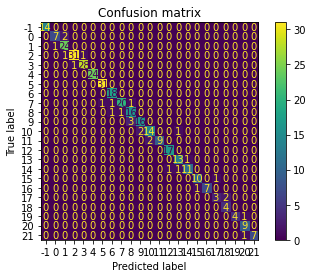

In [39]:
plot_confusion_matrix("round", predict, y_test)

## Summary

In [40]:
results

,Split type,Tuning type,Number of characteristics,MSE,RMSE,MAE
0,chronological,normal,8,0.447566,0.669004,0.327607
1,chronological,Optuna,8,0.409605,0.640004,0.450994
3,random,normal,8,0.243018,0.492968,0.241464
4,random,Optuna,8,0.255307,0.505279,0.322567


In [41]:
from training.results import plot_summary

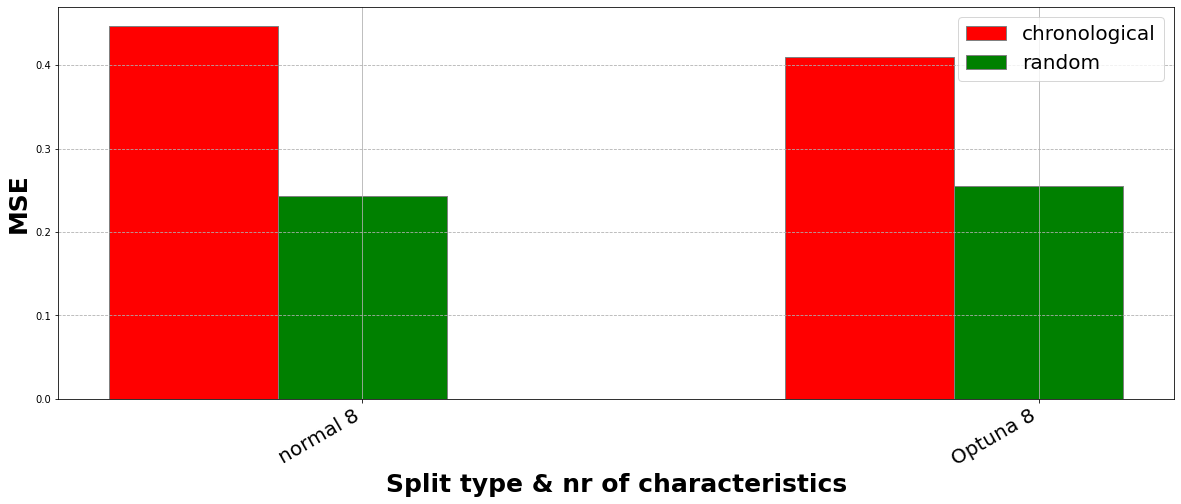

In [42]:
plot_summary(results, "MSE")

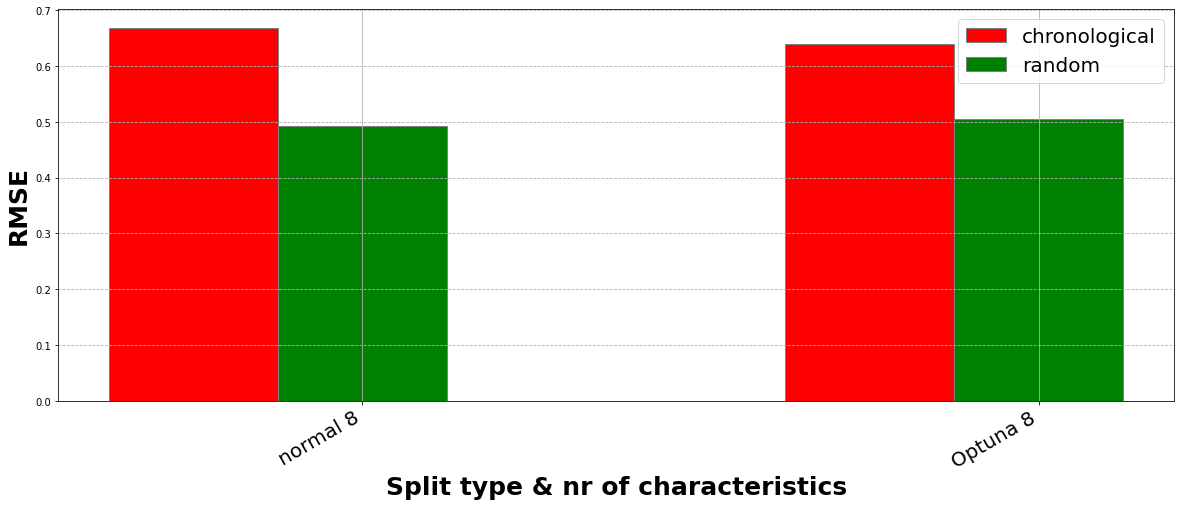

In [43]:
plot_summary(results, "RMSE")

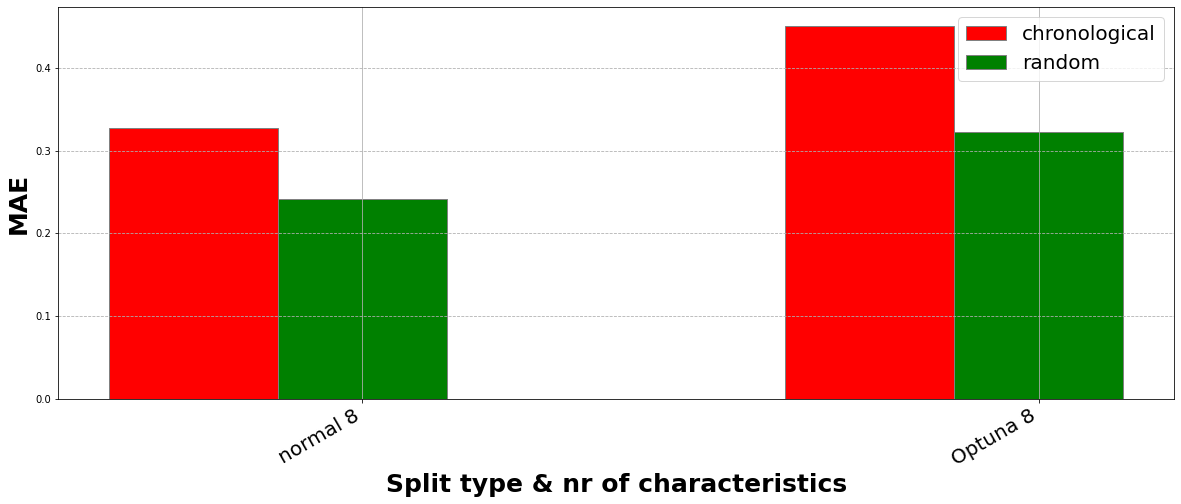

In [44]:
plot_summary(results, "MAE")

In [46]:
results.to_json("./lightgbm_basic_results.json")